<a href="https://colab.research.google.com/github/sungjk1999/smart-factory-quality-classification/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Read train data**

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
drive.mount('/content/gdrive')


"""
PRODUCT_ID : 제품의 고유 ID

Y_Class : 제품 품질 상태(Target) 
    0 : 적정 기준 미달 (부적합) 
    1 : 적합 
    2 : 적정 기준 초과 (부적합)

Y_Quality : 제품 품질 관련 정량적 수치 

TIMESTAMP : 제품이 공정에 들어간 시각 

LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재) 

PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재) 

X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수
"""


dir_path = "/content/gdrive/MyDrive/Colab Notebooks/open"

train = pd.read_csv(f"{dir_path}/train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Remove invalid columns**


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_5,X_7,X_8,X_9,...,X_2861,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870
0,1,0.533433,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,197.286667,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77
1,2,0.541819,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,193.296552,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55
2,1,0.531267,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,179.820690,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35
3,2,0.537325,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,181.920690,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78
4,1,0.531590,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,196.393333,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,0.526546,T100306,T_31,2.0,95.0,10.0,50.0,10.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,0,0.524022,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,180.810345,168.7,384.0,369.811321,353.0,49.47,53.07,50.89,55.10,66.49
595,0,0.521289,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,176.486207,156.6,383.0,367.018868,352.0,NaN,NaN,NaN,NaN,NaN
596,1,0.531375,T100304,O_31,40.0,94.0,11.0,45.0,10.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


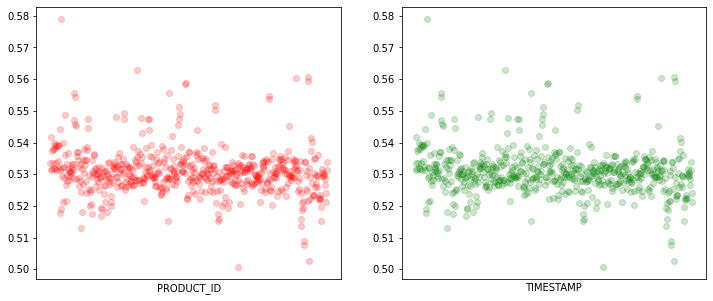

In [93]:
# X_1 ~ X_2875 열의 std가 0 또는 nan인 경우를 제거
# test.csv 에서도 동일하게 적용해야함.

invalid = []

tmp = train.describe()
for col in tmp.columns:
    std = tmp.loc['std', col]
    if std == 0 or np.isnan(std):
        invalid.append(col)

# 아래 두 변수가 실제로 의미가 없는지 판단
PRINT = 1

if PRINT:
    plt.figure(figsize=(12, 5))

    # PRODUCT_ID
    ax = plt.subplot(1, 2, 1)
    ax.axes.xaxis.set_ticks([])
    plt.xlabel("PRODUCT_ID")
    plt.scatter(train["PRODUCT_ID"], y=train["Y_Quality"], c='red', alpha=0.2)

    # TIMESTAMP
    ax = plt.subplot(1, 2, 2)
    ax.axes.xaxis.set_ticks([])
    tmp = train.sort_values('TIMESTAMP')
    plt.xlabel("TIMESTAMP")
    plt.scatter(tmp["TIMESTAMP"], y=tmp["Y_Quality"], c='green', alpha=0.2)

# 실제로 무관하므로 제거
invalid += ["PRODUCT_ID", "TIMESTAMP"]

train = train.drop(columns=invalid)
train

# **How to classify?**



In [94]:
# Y_Quality 값을 통해서, Y_Class를 예측하므로 어느 정도에서 끊기는지 확인
# 정량 데이터이므로, 구간이 겹치지 않는 것을 확인할 수 있음.

over = train[train['Y_Class'] == 2]['Y_Quality']
normal = train[train['Y_Class'] == 1]['Y_Quality']
under = train[train['Y_Class'] == 0]['Y_Quality']

print(f"적정 기준 초과 여부 커트라인 구간: [{normal.max()}, {over.min()}]")
print(f"적정 기준 미달 여부 커트라인 구간: [{under.max()}, {normal.min()}]")

적정 기준 초과 여부 커트라인 구간: [0.534842857, 0.534950794]
적정 기준 미달 여부 커트라인 구간: [0.525066667, 0.525085714]


In [95]:
# 커트라인에 따른 분류 함수1 - 확정적인 경우

def classify(train, y_quality):
    over = train[train['Y_Class'] == 2]['Y_Quality']
    normal = train[train['Y_Class'] == 1]['Y_Quality']
    under = train[train['Y_Class'] == 0]['Y_Quality']
    
    if normal.min() <= y_quality <= normal.max():
        return 1
    elif y_quality <= under.max():
        return 0
    elif over.min() <= y_quality:
        return 2
    else:
        # 커트라인 확정이 안되는 경우
        return -1

In [96]:
# LINE에 따라서 어떻게 분포하는지 확인

lines = set(train['LINE'])

for line in lines:
    print(f"LINE : {line}")
    tmp = train[train['LINE'] == line]['Y_Class'].value_counts()
    print(f"{tmp} \ntotal : {sum(tmp)}")
    print('-' * 79)

LINE : T050307
2    22
0    11
1     9
Name: Y_Class, dtype: int64 
total : 42
-------------------------------------------------------------------------------
LINE : T010306
1    37
2    27
0     6
Name: Y_Class, dtype: int64 
total : 70
-------------------------------------------------------------------------------
LINE : T050304
1    37
0    30
2    11
Name: Y_Class, dtype: int64 
total : 78
-------------------------------------------------------------------------------
LINE : T010305
1    35
0    13
2    11
Name: Y_Class, dtype: int64 
total : 59
-------------------------------------------------------------------------------
LINE : T100304
1    144
0     17
2     14
Name: Y_Class, dtype: int64 
total : 175
-------------------------------------------------------------------------------
LINE : T100306
1    145
2     18
0     11
Name: Y_Class, dtype: int64 
total : 174
-------------------------------------------------------------------------------


In [97]:
# PRODUCT_CODE 에 따라서 어떻게 분포하는지 확인

codes = set(train['PRODUCT_CODE'])

for code in codes:
    print(f"PRODUCT_CODE : {code}")
    tmp = train[train['PRODUCT_CODE'] == code]['Y_Class'].value_counts()
    print(f"{tmp} \ntotal : {sum(tmp)}")
    print('-' * 79)

PRODUCT_CODE : T_31
1    285
2     30
0     28
Name: Y_Class, dtype: int64 
total : 343
-------------------------------------------------------------------------------
PRODUCT_CODE : A_31
1    118
2     71
0     60
Name: Y_Class, dtype: int64 
total : 249
-------------------------------------------------------------------------------
PRODUCT_CODE : O_31
1    4
2    2
Name: Y_Class, dtype: int64 
total : 6
-------------------------------------------------------------------------------


In [98]:
# PRODUCT_CODE 가 어디서 생산되는지 확인
# 생각해보니, 해당 라인에 대해서 고정적으로 생산되는건지 아니면 이번 데이터에서만 이런건지...
# 구분할 수가 없으므로 유의해서 처리해야할 것 같다.

codes = set(train['PRODUCT_CODE'])

for code in codes:
    print(f"PRODUCT_CODE : {code}")
    tmp = train[train['PRODUCT_CODE'] == code]['LINE'].value_counts()
    print(f"{tmp} \ntotal : {sum(tmp)}")
    print('-' * 79)

PRODUCT_CODE : T_31
T100304    172
T100306    171
Name: LINE, dtype: int64 
total : 343
-------------------------------------------------------------------------------
PRODUCT_CODE : A_31
T050304    78
T010306    70
T010305    59
T050307    42
Name: LINE, dtype: int64 
total : 249
-------------------------------------------------------------------------------
PRODUCT_CODE : O_31
T100304    3
T100306    3
Name: LINE, dtype: int64 
total : 6
-------------------------------------------------------------------------------


# **Missing values handling**
데이터프레임을 `PRODUCT_CODE`에 따라서 분리하고, 그렇게 분리된 데이터프레임에서 각 열의 결측값의 개수를 센다.  
**각 열의 값이 전부 결측값이면 해당 열은 학습하지 않는다.**  
**나머지 경우는 결측값을 보간**해주는데, 결측값이 많을수록 부정확하므로 분포를 살펴본다.

In [99]:
# Split dataframe by PRODUCT_CODE
class Product:
    def __init__(self, df):
        self.df = df
        self.counter = self.nan_count()
    
    def nan_count(self):
        counter = {}
        for col in self.df.columns:
            nan = self.df[col].isnull().sum()
            if nan == 0:
                continue
            if nan in counter:
                counter[nan].append(col)
            else:
                counter[nan] = [col]
        return counter

    def remove(self):
        """ 모든 값이 결측치인 열을 제거한 데이터프레임 반환 """
        invalid = self.counter[self.df.shape[0]]
        return self.df.drop(columns=invalid)
    
    def process(self):
        """ 결측치를 보간한 데이터프레임 반환 """
        pass


codes = set(train['PRODUCT_CODE'])
products = {}

for code in codes:
    products[f"{code}"] = Product(train[train['PRODUCT_CODE'] == code])

for code in codes:
    print(code, ':', sorted(products[code].counter))

T_31 : [1, 171, 172, 256, 335, 343]
A_31 : [1, 2, 16, 120, 129, 130, 131, 139, 145, 149, 155, 171, 179, 187, 190, 197, 207, 210, 216, 226, 243, 249]
O_31 : [3, 4, 6]
